<h1 style="text-align:center;">Quantitative Trading</h1>

<br>

<br>

# Initial Deployment

---

In [94]:
# Import the libraries
import requests, time, datetime, pytz, talib, warnings
import yfinance as yf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

##### Customize the Pandas

In [49]:
# Show max rows
pd.set_option('display.max_rows', 200)

In [32]:
# Show max columns
pd.set_option('display.max_columns', None)

In [33]:
# Show 4 decimal point in dataframe
pd.options.display.float_format = "{:,.3f}".format

##### Customize the Matplotlib

In [34]:
# Set the matplotlib style
plt.style.use("seaborn-darkgrid")

##### Turn-Off the Warnings

In [86]:
# Turn off all warnings
warnings.filterwarnings('ignore')

<br>

# Load the Dataset 

---

### TD Ameritrade API

In [88]:
# Function for fetching the minute level dataset
def fetch_minute_dataset(ticker_name = "TSLA"):
    
    # Client ID
    client_id = "E5AXP16J02E3JTODQW9LW7L1AH726L9X"

    # Get the current time
    current_time_epoch = str(int(time.time()) * 1000)

    # Endpoint
    endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(ticker_name)

    # Define the payload                
    payload = {"apikey": client_id,
               #"periodType": "day",
               #"period": "*1",
               "frequencyType": "minute",
               "frequency": "1",
               "endDate": current_time_epoch,        # Use "www.epochconverter.com" for getting the time
               "startDate": "1620826200000",
               "needExtendedHoursData": "false"}      # Only regular market hour

    # Make a request
    content = requests.get(url = endpoint, params = payload)

    # Convert data into a json dictionary
    data = content.json()

    # Get the dataset in dataframe form
    data = pd.DataFrame(data["candles"])
    
    return data

In [89]:
df = fetch_minute_dataset(ticker_name = "SPY")
print("Dataset Shape: ", df.shape)
df

Dataset Shape:  (3901, 6)


,open,high,low,close,volume,datetime
0,411.230,411.710,410.940,411.660,646169,1620826200000
1,411.670,412.100,411.520,411.580,555916,1620826260000
2,411.580,411.880,411.280,411.880,288527,1620826320000
3,411.870,412.050,411.640,411.760,293702,1620826380000
4,411.770,412.040,411.690,411.980,246648,1620826440000
...,...,...,...,...,...,...
3896,418.040,418.110,417.930,418.080,291977,1621972560000
3897,418.079,418.245,418.070,418.205,406079,1621972620000
3898,418.200,418.270,418.110,418.140,519601,1621972680000
3899,418.140,418.310,418.100,418.250,1439211,1621972740000


In [90]:
def add_different_date_columns(df):
    """
    Function for adding date columns (i.e. "datetime", "year", "month", "day", "hour", "minute", "day name").
    """
    
    # Create a "date" only column
    def converter(x):
        x = datetime.datetime.fromtimestamp(x/1000, pytz.timezone("US/Eastern"))
        return "{}/{}/{}".format(x.year, x.month, x.day)

    df["date"] = df["datetime"].map(lambda x: converter(x))
    
    # Create the year, month, day, hour, and minute columns
    df["year"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).year)
    df["month"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).month)
    df["day"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).day)
    df["hour"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).hour)
    df["minute"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).minute)
    df["day name"] = df["datetime"].map(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%A"))
    
    return df

In [91]:
df = add_different_date_columns(df)
print("Dataset Shape: ", df.shape)
print("Unique Hours: ", df["hour"].unique())
df

Dataset Shape:  (3901, 13)
Unique Hours:  [17 18 19 20 21 22 23 15]


,open,high,low,close,volume,datetime,date,year,month,day,hour,minute,day name
0,411.230,411.710,410.940,411.660,646169,1620826200000,2021/5/12,2021,5,12,17,30,Wednesday
1,411.670,412.100,411.520,411.580,555916,1620826260000,2021/5/12,2021,5,12,17,31,Wednesday
2,411.580,411.880,411.280,411.880,288527,1620826320000,2021/5/12,2021,5,12,17,32,Wednesday
3,411.870,412.050,411.640,411.760,293702,1620826380000,2021/5/12,2021,5,12,17,33,Wednesday
4,411.770,412.040,411.690,411.980,246648,1620826440000,2021/5/12,2021,5,12,17,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3896,418.040,418.110,417.930,418.080,291977,1621972560000,2021/5/25,2021,5,25,23,56,Tuesday
3897,418.079,418.245,418.070,418.205,406079,1621972620000,2021/5/25,2021,5,25,23,57,Tuesday
3898,418.200,418.270,418.110,418.140,519601,1621972680000,2021/5/25,2021,5,25,23,58,Tuesday
3899,418.140,418.310,418.100,418.250,1439211,1621972740000,2021/5/25,2021,5,25,23,59,Tuesday


In [92]:
# Get hours from 17 to 23 only
df = df[(df["hour"]>=17) & (df["hour"]<=23)]
print("Unique Hours: ", df["hour"].unique())
df

Unique Hours:  [17 18 19 20 21 22 23]


,open,high,low,close,volume,datetime,date,year,month,day,hour,minute,day name
0,411.230,411.710,410.940,411.660,646169,1620826200000,2021/5/12,2021,5,12,17,30,Wednesday
1,411.670,412.100,411.520,411.580,555916,1620826260000,2021/5/12,2021,5,12,17,31,Wednesday
2,411.580,411.880,411.280,411.880,288527,1620826320000,2021/5/12,2021,5,12,17,32,Wednesday
3,411.870,412.050,411.640,411.760,293702,1620826380000,2021/5/12,2021,5,12,17,33,Wednesday
4,411.770,412.040,411.690,411.980,246648,1620826440000,2021/5/12,2021,5,12,17,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,417.830,418.200,417.810,418.040,474342,1621972500000,2021/5/25,2021,5,25,23,55,Tuesday
3896,418.040,418.110,417.930,418.080,291977,1621972560000,2021/5/25,2021,5,25,23,56,Tuesday
3897,418.079,418.245,418.070,418.205,406079,1621972620000,2021/5/25,2021,5,25,23,57,Tuesday
3898,418.200,418.270,418.110,418.140,519601,1621972680000,2021/5/25,2021,5,25,23,58,Tuesday


In [93]:
# Negate hours with 8 (time difference)
df["hour"] = df["hour"].map(lambda x: int(x-8))
print("Unique Hours: ", df["hour"].unique())
df

Unique Hours:  [ 9 10 11 12 13 14 15]


,open,high,low,close,volume,datetime,date,year,month,day,hour,minute,day name
0,411.230,411.710,410.940,411.660,646169,1620826200000,2021/5/12,2021,5,12,9,30,Wednesday
1,411.670,412.100,411.520,411.580,555916,1620826260000,2021/5/12,2021,5,12,9,31,Wednesday
2,411.580,411.880,411.280,411.880,288527,1620826320000,2021/5/12,2021,5,12,9,32,Wednesday
3,411.870,412.050,411.640,411.760,293702,1620826380000,2021/5/12,2021,5,12,9,33,Wednesday
4,411.770,412.040,411.690,411.980,246648,1620826440000,2021/5/12,2021,5,12,9,34,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,417.830,418.200,417.810,418.040,474342,1621972500000,2021/5/25,2021,5,25,15,55,Tuesday
3896,418.040,418.110,417.930,418.080,291977,1621972560000,2021/5/25,2021,5,25,15,56,Tuesday
3897,418.079,418.245,418.070,418.205,406079,1621972620000,2021/5/25,2021,5,25,15,57,Tuesday
3898,418.200,418.270,418.110,418.140,519601,1621972680000,2021/5/25,2021,5,25,15,58,Tuesday


### Yahoo Finance API

In [144]:
def load_dataset_yf(ticker_name, period='max', interval='1d',):
    
    # Set the ticker
    ticker = yf.Ticker(ticker_name)
    
    # Load the dataset
    df = ticker.history(period, interval).reset_index()
    
    # Rename the columns
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits']

    # Drop some columns
    df = df.drop(["dividends", "stock splits"], axis=1)
    
    return df

In [145]:
df = load_dataset_yf(ticker_name="SPY", period='max', interval='1d',)
df

,date,open,high,low,close,volume
0,1993-01-29,25.903,25.903,25.774,25.884,1003200
1,1993-02-01,25.903,26.068,25.903,26.068,480500
2,1993-02-02,26.050,26.142,25.995,26.123,201300
3,1993-02-03,26.160,26.418,26.142,26.400,529400
4,1993-02-04,26.492,26.565,26.197,26.510,531500
...,...,...,...,...,...,...
7127,2021-05-19,406.920,411.050,405.330,410.860,106467100
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700


<br>

# Feature Engineering

---

### Define Output (i.e. Profit Rate)

In [146]:
# Add price change
df["price diff"] = df['close'].pct_change()
df

,date,open,high,low,close,volume,price diff
0,1993-01-29,25.903,25.903,25.774,25.884,1003200,NaN
1,1993-02-01,25.903,26.068,25.903,26.068,480500,0.007
2,1993-02-02,26.050,26.142,25.995,26.123,201300,0.002
3,1993-02-03,26.160,26.418,26.142,26.400,529400,0.011
4,1993-02-04,26.492,26.565,26.197,26.510,531500,0.004
...,...,...,...,...,...,...,...
7127,2021-05-19,406.920,411.050,405.330,410.860,106467100,-0.003
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010


### Add Indicators

In [147]:
# Add relative volume (i.e. percentage of change in volume)
df["relative volume"] = df["volume"].pct_change()
df

,date,open,high,low,close,volume,price diff,relative volume
0,1993-01-29,25.903,25.903,25.774,25.884,1003200,NaN,NaN
1,1993-02-01,25.903,26.068,25.903,26.068,480500,0.007,-0.521
2,1993-02-02,26.050,26.142,25.995,26.123,201300,0.002,-0.581
3,1993-02-03,26.160,26.418,26.142,26.400,529400,0.011,1.630
4,1993-02-04,26.492,26.565,26.197,26.510,531500,0.004,0.004
...,...,...,...,...,...,...,...,...
7127,2021-05-19,406.920,411.050,405.330,410.860,106467100,-0.003,0.780
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,-0.267
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,-0.019
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,-0.329


In [148]:
# Add RSI
time_periods = [14]
for i in time_periods:
    df.loc[:, f"RSI_{i}"] = talib.RSI(df["close"], timeperiod = i)

In [149]:
# Add EMA
time_periods = [9, 20, 50, 200]
for i in time_periods:
    df.loc[:, f"EMA_{i}"] = talib.EMA(df["close"], timeperiod = i)

In [150]:
# Add MACD
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(df["close"], fastperiod=12, slowperiod=26, signalperiod=9)

In [151]:
# TODO: Add more indicator

In [152]:
# Replace infinity with NaN
df = df.replace([np.inf, -np.inf], np.nan)

In [153]:
# Remove rows with NaN values
df.dropna(inplace=True)

In [154]:
df

,date,open,high,low,close,volume,price diff,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist
199,1993-11-11,27.891,27.966,27.797,27.816,88900,-0.003,0.912,50.310,27.805,27.826,27.687,26.869,0.008,0.043,-0.034
200,1993-11-12,27.872,28.041,27.853,27.947,108200,0.005,0.217,54.494,27.834,27.837,27.697,26.880,0.018,0.038,-0.020
201,1993-11-15,28.003,28.003,27.853,27.928,243300,-0.001,1.249,53.797,27.853,27.846,27.706,26.890,0.024,0.035,-0.011
202,1993-11-16,27.985,28.078,27.872,28.060,492600,0.005,1.025,57.860,27.894,27.866,27.720,26.902,0.039,0.036,0.003
203,1993-11-17,28.078,28.078,27.835,27.910,39600,-0.005,-0.920,52.209,27.897,27.870,27.728,26.912,0.038,0.036,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7127,2021-05-19,406.920,411.050,405.330,410.860,106467100,-0.003,0.780,47.991,413.481,413.584,406.878,372.408,1.207,2.560,-1.353
7128,2021-05-20,411.800,416.630,411.670,415.280,78022200,0.011,-0.267,53.255,413.841,413.746,407.208,372.835,1.232,2.295,-1.062
7129,2021-05-21,416.870,418.200,414.450,414.940,76519100,-0.001,-0.019,52.813,414.061,413.860,407.511,373.254,1.211,2.078,-0.867
7130,2021-05-24,417.340,420.320,417.080,419.170,51376700,0.010,-0.329,57.543,415.083,414.365,407.968,373.710,1.518,1.966,-0.448


### Add Trendlines + Support and Resistance Levels

In [ ]:
# TODO: 

### Add Correlated Asset Classes

In [ ]:
# TODO: 

In [163]:
# Add gold price
gold = load_dataset_yf(ticker_name="GOLD")
df = df.merge(gold[["date", "close"]].rename({"close":"gold price"}, axis=1), on="date")
df

,date,open,high,low,close,volume,price diff,relative volume,RSI_14,EMA_9,EMA_20,EMA_50,EMA_200,macd,macdsignal,macdhist,gold price_x,gold price_y
0,2005-12-06,93.155,93.661,92.847,92.986,57935200,0.002,-0.023,66.375,92.593,91.743,90.390,88.111,1.031,1.031,-0.000,2.400,22.551
1,2005-12-07,92.949,93.023,92.150,92.443,66816500,-0.006,0.153,60.107,92.563,91.810,90.470,88.154,0.960,1.017,-0.057,2.180,23.236
2,2005-12-08,92.546,92.986,92.003,92.385,62608600,-0.001,-0.063,59.453,92.527,91.864,90.545,88.196,0.889,0.992,-0.102,2.320,23.562
3,2005-12-09,92.502,92.957,92.253,92.627,50744500,0.003,-0.189,61.321,92.547,91.937,90.627,88.240,0.843,0.962,-0.119,2.340,23.203
4,2005-12-13,92.693,93.631,92.597,93.345,88630900,0.007,0.832,66.579,92.734,92.138,90.812,88.335,0.815,0.907,-0.093,2.320,22.977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,2015-03-26,182.544,183.800,181.796,182.821,153067200,-0.002,-0.040,44.087,184.770,184.871,183.837,176.872,0.115,0.363,-0.249,4.240,10.597
2262,2016-01-27,171.565,173.357,169.284,170.253,185681700,-0.011,0.317,39.092,171.433,174.476,178.991,181.602,-3.618,-3.546,-0.071,12.030,9.329
2263,2016-09-28,198.346,199.256,197.316,199.090,87411000,0.005,0.114,54.177,197.942,197.910,197.282,190.739,-0.048,-0.220,0.172,17.480,17.148
2264,2016-10-26,195.938,197.050,195.681,196.425,75705500,-0.002,0.138,46.739,196.707,196.948,197.088,191.877,-0.314,-0.347,0.033,17.760,15.844


In [ ]:
# Add gold price
gold = load_dataset_yf(ticker_name="GOLD")
df = df.merge(gold[["date", "close"]].rename({"close":"gold price"}, axis=1), on="date")
df

### Add Fundamental Information

In [ ]:
# TODO: 

### Add News Sentiment

In [ ]:
# TODO: 

### Feature Importance & Feature Selection

In [168]:
# Get the x and y
X=df.drop(["price diff", "date", "year", "month", "day", "hour", "minute", "datetime", "day name"], axis=1)
y=df[["price diff"]]

In [170]:
# Scale the data
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [171]:
# Convert to dataframe + Change the column names
df_scaled = pd.DataFrame(X_scaled, columns=list(X.columns.values))

In [173]:
# Add the target output to the dataframe
df_scaled["output"] = y["price diff"].reset_index().iloc[:, 1:]

##### Filter Method

In [175]:
# Get the correlation matrix
correlation_matrix = df_scaled.corr()

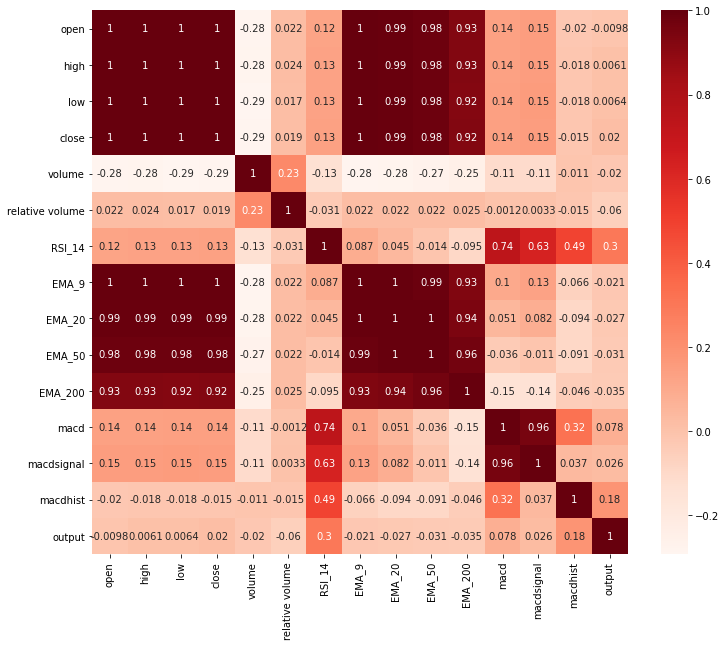

In [184]:
# Visualize the correlation map
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

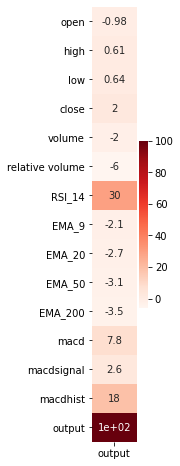

In [185]:
# Visualize the correlation map related to output only
plt.figure(figsize=(1,8))
sns.heatmap(df_scaled.corr()[["output"]]*100, annot=True, cmap=plt.cm.Reds)
plt.show()

In [186]:
# TODO: Drop columns that have near to zero correlation (i.e. less than 0.5)


In [187]:
# TODO: Drop columns that have high correlation


##### Wrapper Methods - Backward Elimination

In [ ]:
# Initialize the model
model = ridge_regressor()

# Fit the model
model.fit(X=x_train, y=y_train)

# Get the p-values
model.pvalues

In [ ]:
# Get the columns
cols = list(X.columns)

# Set the maximum p value
pmax = 1

# While length of column is bigger than zero
while(len(cols)>0):
    
    # Initialize a list for p values
    p = []
    
    #
    X_1 = X[cols]
    
    # Initialize the model
    model = Ridge()
    
    # Fit to the model
    model.fit(X=X_1, y=y_train)
    
    # Get the p-values inside a series
    p = pd.Series(model.pvalues.values(), index=cols)
    
    # Get the pmax
    pmax = max(p)
    
    # Get the features with pmax
    feature_with_p_max = p.idxmax()
    
    # If pmax is bigger than 0.05
    if (pmax>0.05):
        
        # Remove the feature from columns
        cols.remove(feature_with_p_max)
        
    # If pmax is less than 0.05
    else:
        
        # Break the loop
        break
        
# Set the selected features
selected_features = cols
print(selected_features)

In [ ]:
# Backward Elimination - dropping columns which their pvalue is above 0.05
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

##### Wrapper Methods - RFE (Recursive Feature Elimination)

In [ ]:
# Rank the columns (1 being the most important one)
model = LinearRegression()
rfe = feature_selection.RFE(model, n_features_to_select=7)
X_rfe = rfe.fit_transform(X_scaled,y)  
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
pd.DataFrame(rfe.ranking_, index=X.columns, columns=["Rank"])

In [ ]:
# Get the optimal number of features
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
# Feed the optial number of features as number of features to RFE and get the final set of features
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

##### Embedded Method

In [195]:
X = df_scaled.drop("output", axis=1).to_numpy()
y = df_scaled["output"].to_numpy()

In [196]:
n_sample = 100000
X_sample = X[:n_sample]
y_sample = y[:n_sample]

In [197]:
model_tree = GradientBoostingRegressor(n_estimators=100)
model_tree.fit(X_sample, y_sample)
model_tree.feature_importances_ 

array([3.05484532e-02, 6.93883192e-04, 1.17957307e-03, 2.58839988e-02,
       4.82117903e-02, 7.47455800e-02, 4.92765811e-01, 2.98294154e-04,
       6.18834064e-03, 1.47045336e-03, 9.51538043e-03, 1.21470542e-01,
       1.64545416e-01, 2.24824836e-02])

In [198]:
model_ridge = Ridge()
model_ridge.fit(X_sample, y_sample)
model_ridge.coef_

array([-5.01700596e-03,  1.52498034e-03,  1.10722318e-03,  7.24627155e-03,
        4.64342553e-06, -1.10116449e-05,  1.41282297e-05, -2.27735992e-03,
       -2.49511178e-03, -1.44703989e-04,  7.05506960e-05, -1.39941905e-04,
       -8.22299792e-05, -2.16650935e-04])

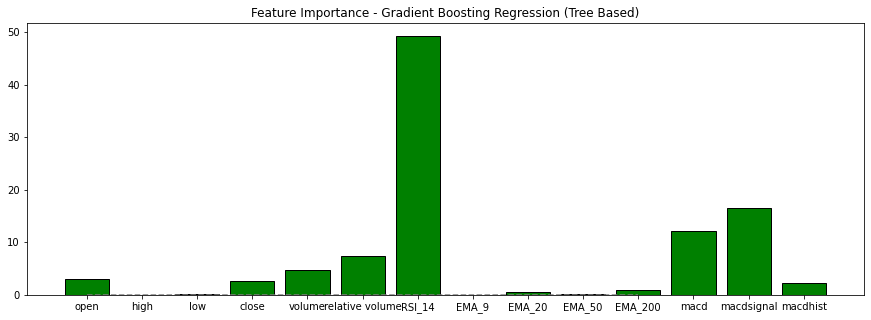

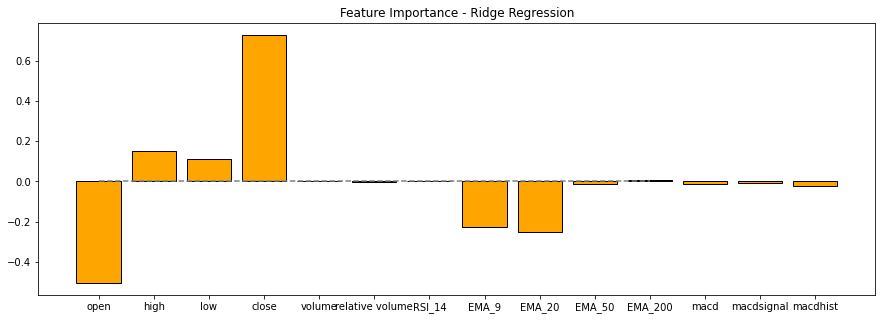

In [199]:
plt.figure(figsize=(15,5))
f1 = pd.DataFrame(model_tree.feature_importances_*100, index=list(df_scaled.drop("output", axis=1).columns.values))
plt.bar(x = list(f1.index),
        height = f1[0].values,
        color="green",
        edgecolor="black")
plt.hlines(0, 0, 10, linestyles="dashed", color="gray")
plt.title("Feature Importance - Gradient Boosting Regression (Tree Based)")
plt.show()

plt.figure(figsize=(15,5))
f2 = pd.DataFrame(model_ridge.coef_*100, index=list(df_scaled.drop("output", axis=1).columns.values))
plt.bar(x = list(f2.index),
        height = f2[0].values,
        color="orange",
        edgecolor="black")
plt.hlines(0, 0, 10, linestyles="dashed", color="gray")
plt.title("Feature Importance - Ridge Regression")
plt.show()